In [2]:
# Import library
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
import time

import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import time
from tqdm import tqdm_notebook as tqdm
from IPython.display import IFrame

# Ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for randomization
seed = 0

In [3]:
# def download_file(url):
#     '''
#     Download file from given URL
    
#     Parameters
#     ----------
#     url: str
#         URL of the file to download
#     '''
    
#     # One chunk = 1KB = 1024 byte
#     chunk_size = 1024
#     # Create a request object to download the file in streaming mode
#     r = requests.get(url, stream = True)
#     # Get the total size of the file
#     total_size = int(r.headers['content-length'])
#     # Use the original filename (The string after the last "/")
#     filename = url.split('/')[-1]
    
#     # Open a new file with filename and write the download data
#     with open(filename, 'wb') as f:
#         # Use tqdm to show download progress
#         for data in tqdm(iterable = r.iter_content(chunk_size = chunk_size), 
#                          total = total_size/chunk_size, unit ='KB'):
#             # Write the data to file
#             f.write(data)
            
#     print('Donwload complete')

In [4]:
# # The URL of the Green Taxis data from March 2018
# url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-03.csv"
# # Download
# download_file(url)

In [5]:
# # The URL of the Green Taxis data from August 2018
# url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-08.csv"
# # Download
# download_file(url)

In [151]:
data = pd.read_csv('../data/yellow_tripdata_2018-03.csv')
data.shape

(9430376, 17)

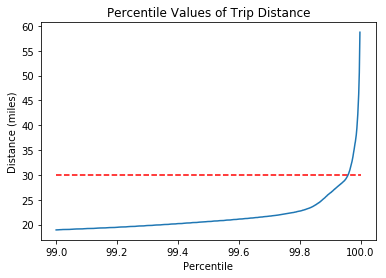

In [152]:
# Compute the value of Trip_distance for percentiles of 99.000, 99.001, ..., 99.999
X = np.arange(99,99.999,0.001)
Y = [np.percentile(data.trip_distance, x) for x in X]
# Visualize the percentile values
ax = sns.lineplot(x = X, y = Y)
ax.hlines(30, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed') # Add horizontal red dashed line at 30
ax.set_title('Percentile Values of Trip Distance');
ax.set_xlabel('Percentile'); ax.set_ylabel('Distance (miles)');

In [153]:
# The percentile that has value of 30 for Trip_distance
print('Roughly {:.2f}% of the trip records have Trip_distance roughly less than 30 miles'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-30))])) 

Roughly 99.96% of the trip records have Trip_distance roughly less than 30 miles


In [18]:
def taxi_data_preprocess(taxi_data):
    # Convert data type for categorical attribute
    taxi_data.VendorID = taxi_data.VendorID.astype(object)
    taxi_data.RatecodeID = taxi_data.RatecodeID.astype(object)
    taxi_data.PULocationID = taxi_data.PULocationID.astype(object)
    taxi_data.DOLocationID = taxi_data.DOLocationID.astype(object)
    taxi_data.payment_type = taxi_data.payment_type.astype(object)
    # Convert data type for date attribute
    taxi_data.tpep_pickup_datetime = pd.to_datetime(taxi_data.tpep_pickup_datetime)
    taxi_data.tpep_dropoff_datetime = pd.to_datetime(taxi_data.tpep_dropoff_datetime)
    
    # Compute the duration of each trip and store in a new column, 'duration'
    print('Compute the duration of each taxi trip...')
    taxi_data['duration'] = taxi_data.tpep_dropoff_datetime - taxi_data.tpep_pickup_datetime
    # Create 5 different time period
    print('Create 5 different time period: morning, noon, afternoon, night, latenight...')
    taxi_data['time'] = None
    
    morning = [6 <= time.hour < 11 for time in taxi_data.tpep_pickup_datetime]
    print('Morning is done!')
    noon = [11 <= time.hour < 14 for time in taxi_data.tpep_pickup_datetime]
    print('Noon is done!')
    afternoon = [14 <= time.hour < 18 for time in taxi_data.tpep_pickup_datetime]
    print('Afternoon is done!')
    night = [18 <= time.hour <= 23 for time in taxi_data.tpep_pickup_datetime]
    print('Night is done!')
    latenight = [0 <= time.hour < 6 for time in taxi_data.tpep_pickup_datetime]
    print('Latenight is done!')
    
    
    taxi_data.loc[morning,'time'] = 'Morning'
    taxi_data.loc[noon,'time'] = 'Noon'
    taxi_data.loc[afternoon,'time'] = 'Afternoon'
    taxi_data.loc[night,'time'] = 'Night'
    taxi_data.loc[latenight,'time'] = 'Latenight'
    
    # Remove unreasonable records
    print('Remove unreasonable records...')
    # 1. Taxi trips that last longer than 24 hours
    print('Remove trip records that last longer than 24 hours...')
    taxi_data = taxi_data.loc[[duration.days == 0 for duration in taxi_data.duration],]
    # 2. Taxi trips that travel more than 30 miles
    print('Remove trip records that travel more than 30 miles...')
    taxi_data = taxi_data.loc[taxi_data.trip_distance <= 30,]
    # 3. Taxi trips with non-positive total amount 
    print('Remove trip records that have negative or zero total amount...')
    taxi_data = taxi_data.loc[taxi_data.total_amount > 0,]
    
    # Reset row index
    print('Reset row index...')
    taxi_data.reset_index(inplace = True)
    
    
    print('Taxi data preprocess completed!')
    
    return taxi_data

In [7]:
# def fall_into(warning, taxi_trip):
#     if taxi_trip.tpep_pickup_datetime > warning.start and taxi_trip.tpep_dropoff_datetime < warning.end:
#         return True
#     else:
#         return False

In [8]:
# def add_weather(taxi_data, weather_path):
#     # Read weather data
#     weather_data = pd.read_csv(weather_path)
#     # Remove warning duplicates
#     weather_data.drop_duplicates(inplace=True)
#     # Reset row index
#     weather_data.reset_index(inplace=True, drop=True)
#     # Create timestamp from numeric value
#     weather_data.start = [datetime.strptime(str(time),'%Y%m%d%H%M') for time in weather_data.start]
#     weather_data.end = [datetime.strptime(str(time),'%Y%m%d%H%M') for time in weather_data.end]
#     # Create weather column in taxi data
#     taxi_data['weather'] = None
    
#     # Mark taxi trips that fall into NWS weather warning
#     for i in tqdm(range(taxi_data.shape[0])):
#         for j in range(weather_data.shape[0]):
#             if fall_into(warning = weather_data.iloc[j,], taxi_trip = taxi_data.iloc[i,]):
#                 taxi_data.loc[i,'weather'] = weather_data.loc[j,'PHENOM']
#                 break
    
#     return taxi_data

In [9]:
def add_March_weather(taxi_data):
    print('Add weather warnings for March data...')
    # Create weather column in taxi data
    taxi_data['weather'] = None
    # List of dates that have winter storm warning
    winter_storm_date = [6,7,8,20,22]
    # True/False vector to indicate whether trip was impacted by the weather or not
    impact = [time.day in winter_storm_date for time in taxi_data.tpep_pickup_datetime]
    # Label impacted trips
    taxi_data.loc[impact,'weather'] = 'Winter Storm'
    print('Weather warnings have been added!')
    
    return taxi_data

In [10]:
def add_August_weather(taxi_data):
    print('Add weather warnings for August data...')
    # Create weather column in taxi data
    taxi_data['weather'] = None
    # List of dates that have winter storm warning
    thunderstorm_date = [7,11]
    # True/False vector to indicate whether trip was impacted by the weather or not
    impact = [time.day in thunderstorm_date for time in taxi_data.tpep_pickup_datetime]
    # Label impacted trips
    taxi_data.loc[impact,'weather'] = 'Thunderstorm'
    print('Weather warnings have been added!')
    
    return taxi_data

In [11]:
# Read weather data
weather_data = pd.read_csv('../data/NYC_2018_weather.csv')
# Remove warning duplicates
weather_data.drop_duplicates(inplace=True)
# Reset row index
weather_data.reset_index(inplace=True, drop=True)
# Create timestamp from numeric value
weather_data.start = [datetime.strptime(str(time),'%Y%m%d%H%M') for time in weather_data.start]
weather_data.end = [datetime.strptime(str(time),'%Y%m%d%H%M') for time in weather_data.end]
weather_data

,PHENOM,start,end
0,WS,2018-01-03 20:20:00,2018-01-05 06:00:00
1,WS,2018-02-17 08:32:00,2018-02-18 12:00:00
2,WS,2018-03-06 08:49:00,2018-03-08 09:00:00
3,WS,2018-03-07 09:11:00,2018-03-08 09:00:00
4,WS,2018-03-20 07:44:00,2018-03-22 12:00:00
5,SV,2018-05-15 20:51:00,2018-05-15 21:45:00
6,SV,2018-05-15 21:28:00,2018-05-15 22:15:00
7,SV,2018-07-27 20:45:00,2018-07-27 21:30:00
8,SV,2018-07-27 21:14:00,2018-07-27 22:00:00
9,TO,2018-08-03 02:18:00,2018-08-03 02:45:00


In [20]:
start = time.time()
# Load the csv file into pandas dataframe
taxi_data = pd.read_csv('../data/yellow_tripdata_2018-03.csv')
# Preprocess the taxi data
taxi_data = taxi_data_preprocess(taxi_data)
# Add weather info
# taxi_data = add_weather(taxi_data=taxi_data, weather_path='../data/NYC_2018_weather.csv')
taxi_data = add_March_weather(taxi_data=taxi_data)
end = time.time()
print('Entire process took {:.2f} minutes'.format((end-start)/60))

Compute the duration of each taxi trip...
Create 5 different time period: morning, noon, afternoon, night, latenight...
Morning is done!
Noon is done!
Afternoon is done!
Night is done!
Latenight is done!
Remove unreasonable records...
Remove trip records that last longer than 24 hours...
Remove trip records that travel more than 30 miles...
Remove trip records that have negative or zero total amount...
Reset row index...
Taxi data preprocess completed!
Add weather warnings for March data...
Weather warnings have been added!
Entire process took 5.13 minutes


In [13]:
taxi_data.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,time,weather
0,0,1,2018-03-01 00:01:34,2018-03-01 00:01:43,1,0.0,1,N,145,145,...,2.5,0.5,0.5,0.00,0.0,0.3,3.80,00:00:09,None,None
1,1,1,2018-03-01 00:14:34,2018-03-01 00:28:13,1,3.3,1,N,151,244,...,13.0,0.5,0.5,2.85,0.0,0.3,17.15,00:13:39,None,None
2,2,1,2018-03-01 00:51:25,2018-03-01 00:59:54,1,2.7,1,N,238,152,...,10.0,0.5,0.5,0.00,0.0,0.3,11.30,00:08:29,None,None
3,3,1,2018-03-01 00:00:01,2018-03-01 00:00:17,1,0.0,1,N,145,145,...,2.5,0.5,0.5,0.00,0.0,0.3,3.80,00:00:16,None,None
4,4,1,2018-03-01 00:55:10,2018-03-01 00:56:36,1,3.7,1,N,145,145,...,3.0,0.5,0.5,0.00,0.0,0.3,4.30,00:01:26,None,None


In [75]:
taxi_data.shape

(9419965, 20)

In [19]:
taxi_data.time.value_counts()

Night        3164598
Afternoon    2024345
Morning      1899190
Noon         1403253
Latenight     631107
Name: time, dtype: int64